# Faziesklassifizierung mit Support Vector Machines
<a id="intro"></a>
### Inhalt:  
* [Arbeitsschritte](#Arbeitsschritte)  
* [Analyse der Datensätze](#Analyse-daten)  
    * [Information über die Datensätze](#info_daten)
    * [Kategorien](#kategorie)  
    * [Vollständigkeit](#vollstaendig)
* [Vorbereitung der Datensätze](#Konditionierung-daten)
* [Erstellung der SVMs](#SVM-training)
* [Anwendung der trainierten SVMs](#Blind-test)

Dieses Jupyter Notebook dient als Leitfaden für die Abschlussarbeit in der Lehrveranstaltung *Data Mining*. In diesem Notebook werden Sie zwei bestimmte machine learning Algorithmen trainieren, die automatisch Fazies anhand von geophysikalischen Logdaten vorhersagen sollen. 

In der Lehrveranstaltung haben Sie Support Vector Machines (`SVMs`) kennengelernt, eine Methode im Bereich des überwachten Lernens (englisch *supervised learning*). `SVMs` können für Regressions- und Klassifizierungsaufgaben an Daten trainiert werden, indem sie Parameter für eine Hyperebene optimieren, die verschiedene Klassen (hier Fazies) trennt. Neue Daten können dann entsprechend ihren Werten Klassen zugeordnet werden. Im Falle der Faziesklassifizierung durch `SVMs` hieße das:  
Auf Basis von Log-Daten aus einem neuen Bohrloch kann die ausreichend trainierte `SVM` die zugehörige Faziesverteilung vorhersagen.  

In diesem Notebook werden Sie die Implementierung von `SVMs` aus der Python Bibliothek [`scikit-learn`](http://scikit-learn.org/stable/modules/svm.html) benutzen.  


<br>
<div class="alert-danger">
<br><center>Hinweis: Fremde Arbeit nicht zu kennzeichnen und als eigene auszugeben ist versuchte Täuschung in der Prüfungsleistung.</center>
<br>
</div>



<hr>  

Dieses Notebook basiert auf dem Jupyter Notebook zum Paper: "[Facies classification using machine learning](https://library.seg.org/doi/pdf/10.1190/tle35100906.1)" von [Brendon Hall](http://blog.enthought.com/author/bhall/)  

<hr>  

### Literatur:   

Al-Anazi, A., & Gates, I. D. (2010). A support vector machine algorithm to classify lithofacies and model permeability in heterogeneous reservoirs. *Engineering Geology*, **114**(3-4), 267-277.  

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, **34** (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)  

Bohling, G. C., & Dubois, M. K. (2003). An integrated application of neural network and Markov chain techniques to prediction of lithofacies from well logs. *Kansas Geol Survey Open File Report*, **50**(6). [link](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., Bohling, G. C., & Chakrabarti, S. (2007). Comparison of four approaches to a rock facies classification problem. *Computers & Geosciences*, **33**(5), 599-617.  

Hall, B. (2016). Facies classification using machine learning. *The Leading Edge*, **35**(10), 906-909. [link](https://library.seg.org/doi/pdf/10.1190/tle35100906.1)  


## Arbeitsschritte  
<a id="Arbeitsschritte"></a>
Die Schritte, die Sie in diesem Notebook ausführen sollen, umfassen:  

1. [Analyse der Datensätze](#Analyse-daten): Sie sollen die zwei Trainingsdatensätze laden und analysieren. Was ist der Umfang der Datensätze? Wie kann die Varianz in den Datensätzen abgeschätzt werden? Wie vollständig sind die Datensätze?  
    * *Training_single_well.csv* enthält Daten eines einzelnen Bohrlochs.  
    * *Training_multiple_wells.csv* enthält Daten mehrerer Bohrlöcher. 

2. [Vorbereitung der Datensätze](#Konditionierung-daten):  Basierend auf den Ergebnissen des ersten Schritts: Müssen die Datensätze vor Weitergabe an die SVM bearbeitet werden? Müssen die Datensätze konditioniert, und oder standardisiert werden?

3. [Erstellung der SVMs](#SVM-training): Mit den im 2. Schritt bereiteten Daten sollen zwei SVMs trainiert werden (siehe Auflistung). Nutzen Sie eine Vergleichsprüfung, um die Modellparameter der SVMs (C und gamma) zu finden, welche die Klassifizierung optimieren.

    * `SVM-single` an dem bearbeiteten Datensatz *Training_single_well*  
    * `SVM-multi` an dem bearbeiteten Datensatz *Training_multiple_wells*   

4. [Anwendung der trainierten SVMs](#Blind-test): Wenn beide Klassifizierungsmethoden bestmöglich eingestellt wurden, wenden Sie sie auf Bohrlochdaten an, welche bisher keine Faziesklassifizierung haben (Datensatz *Blind_single_well.csv*).

<hr>
<center> Bitte tragen Sie in der unten stehenden Zelle Ihren Namen und Matrikelnummer ein. </center>
<hr>

In [1]:
NAME = "Aaron Foerderer"
MATNUM = "399992"

In [2]:
### import libraries and data, display data
### contains all necessary libraries. If you need additional libraries, import here!
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns; sns.set(style="ticks", color_codes=True)
from tabulate import tabulate

### SKLEARN functions
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [3]:
### Functions for plotting. You can use those for plotting Logs together with facies. 
### The same functions that you know from the exercise.
### YOU DO NOT NEED TO CHANGE ANYTHING IN THIS CELL

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

# Funktion zur Errechnung der Genauigkeit einer Confusion Matrix
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

The following cells contain some functions I wrote to reduce lines of code further down:

In [4]:
#Function 1: returns all facies that are present in the given dataset (only needed if .unique() can not be used)
def get_unique_facies(data): 
    unique_facies = []
    for facies in data:
        if facies not in unique_facies:
            unique_facies.append(facies)
    return unique_facies, len(unique_facies)

#2 Creates a matrix in which the accuracies of SVMs are calculated for a range of C and gamma values
#in each loop an SVM with a specific C-gamma combination is created and trained with the input training data
#using the accuracy function, the SVM's accuracy is calculated by predicting the given cv-dataset's facies
#arguments are the training features and facies, the cv features and facies, the desired kernel functions and
#lists of the gamma and C-values that shall be used
def get_accuracy_matrix(features_train, facies_train, features_cv, facies_cv, kernel, C_range, gamma_range):
    accuracies = []
    for c_value in C_range:
        temp_results = [] #this temporary list stores the accuracies for one c-value and all gamma values
        for gamma_value in gamma_range:
            clf = svm.SVC(C=c_value,gamma=gamma_value,kernel=kernel) #here the SVM is initialized for the c-and gamma values of the current loop state
            clf.fit(features_train,facies_train)
            
            #the creation of the confusion matrix and the accuracy function are done in this single line of code
            temp_results.append(round(accuracy(confusion_matrix(facies_cv, clf.predict(features_cv))),2)) 
        
        accuracies.append(temp_results) #the temporary list is appended to the output matrix
        #this loop is repeated for all c-values
    return accuracies #the complete matrix of accuracies for all C-& gamma values is returned


#3 the same function as above but with the accuracy_adjacent calculation
#takes the list of adjacent facies as an additional argument
#returns a matrix of accuracies for SVMs trained with a range of C- and gamma values
def get_accuracy_adjacent_matrix(features_train, facies_train, features_cv, facies_cv, adjacent_facies, kernel, C_range, gamma_range):
    accuracies = []
    for c_value in C_range:
        temp_results = [] #this temporary list stores the accuracies for the current c-value and all gamma values
        for gamma_value in gamma_range:
            #here the SVM is initialized for the c-and gamma values of the current loop state
            clf = svm.SVC(C=c_value,gamma=gamma_value) 
            clf.fit(features_train,facies_train)
            
            #the creation of the confusion matrix and the accuracy function are done in this single line of code
            temp_results.append(round(accuracy_adjacent(confusion_matrix(facies_cv, clf.predict(features_cv)),adjacent_facies),2)) 
        
        accuracies.append(temp_results) #the for-loops create a list with the accuracies for one c-value in combination with all gamma values
        #this loop is repeated for all c-values
    return accuracies #the complete matrix of accuracies is returned



## Analyse der Datensätze
<a id="Analyse-daten"></a>
In den folgenden Zellen Sollen sie die zwei Trainingsdatensätze, die zum Anlernen der `SVMs` genutzt werden sollen, in Augenschein nehmen. Die Datensätze bestehen aus Messungen von Bohrloch-logs pro Bohrloch. Möglicherweise besitzen einzelne Log Signale jedoch Artefakte oder fehlende Einträge. Sollte das der Fall sein, müssen die Datensätze vor Anwendung auf eine `SVM` entsprechend aufbereitet werden.

Die Datensätze, welche als Trainingsdaten genutzt werden sollen, heißen `Training_single_well_n.csv` und `Training_multiple_wells_n.csv`, wobei `n` eine natürliche Zahl zwischen 0 und 19 ist. Datensätze können Sie mit mehreren Methoden in Python laden, empfohlen wird jedoch die Bibliothek *pandas* zu nutzen.



### Information über die Datensätze
<a id="info_daten"></a>
Die bereitgestellten Datensätze stammen aus dem Panoma Council Grove Gas Reservoir in Southwest Kansas.
Jedes Bohrloch in den Datensätzen umfasst sieben [Einflussgrößen](https://de.wikipedia.org/wiki/Einflussgr%C3%B6%C3%9Fe_und_Zielgr%C3%B6%C3%9Fe) (Logdaten und Geologische Daten), sowie eine zugehörige Klasse (die zugehörige Fazies). 

Die sieben Einflussvariablen sind:
* Fünf bohrloch-log Signale [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Zwei, auf geologischem Wissen beruhende Variablen: *nonmarine-marine indicator (NM_M)* und *relative Position (RELPOS)*

<hr>

Neun unterschiedliche Fazies wurden aus Kernproben abgeleitet, sind aber nicht immer eindeutig. Durch Sedimentation bedingt, gehen Fazies graduell ineinander über. Dies bedeutet, dass angrenzende Fazies falsch klassifiziert worden sein können. In der nachfolgenden Tabelle sind die neun Fazies aufgelistet, zusammen mit Abkürzungen und den angrenzenden Fazies (**Beispiel**: Fazies 2 ist üblicherweise angrenzend zu Fazies 1 und 3 zu finden). 


Facies |Label| Adjacent Facies
:---| :---: |---:
**1** Nonmarine sandstone |SS| 2
**2** Nonmarine coarse siltstone  |CSiS| 1,3
**3** Nonmarine fine siltstone  |FSiS| 2
**4** Marine siltstone and shale  |SiSh| 5
**5** Mudstone (limestone) |MS| 4,6
**6** Wackestone (limestone) |WS| 5,7
**7** Dolomite |D| 6,8
**8** Packstone-grainstone (limestone) |PS| 6,7,9
**9** Phylloid-algal bafflestone (limestone) |BS| 7,8


In [5]:
### Einladen der beiden Trainingsdatensätze. training_single für den Datensatz mit einem Bohrloch
### training_multi für den Datensatz mit mehreren Bohrlöchern

training_single = pd.read_csv('Training_single_well_8.csv')
training_multiple = pd.read_csv('Training_multiple_wells_8.csv') 

I like to take a quick preview of the loaded datasets.

First the single well training data:

In [6]:
pd.set_option("display.max_rows", 10)
training_single


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000,CSiS
1,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984,CSiS
2,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968,CSiS
3,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952,CSiS
4,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935,CSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
444,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060,PS
445,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045,PS
446,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030,PS
447,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030,SiSh


And secondly the multiple well training data:

In [7]:
training_multiple


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,LUKE G U,2610.5,74.900,0.782,9.300,11.750,4.084,1,1.000,FSiS
1,3,A1 SH,LUKE G U,2611.0,83.800,0.745,12.000,13.100,3.501,1,0.981,FSiS
2,3,A1 SH,LUKE G U,2611.5,86.970,0.726,12.900,12.550,3.400,1,0.962,FSiS
3,3,A1 SH,LUKE G U,2612.0,84.430,0.708,13.200,12.000,3.400,1,0.943,FSiS
4,3,A1 SH,LUKE G U,2612.5,78.510,0.708,11.800,11.400,3.400,1,0.925,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
2307,9,B5 LM,Recruit F9,3079.0,185.250,0.830,3.480,7.995,3.912,2,0.167,BS
2308,9,B5 LM,Recruit F9,3079.5,222.500,0.852,4.614,6.959,3.557,2,0.150,BS
2309,9,B5 LM,Recruit F9,3080.0,74.000,0.768,0.243,9.670,5.672,2,0.200,BS
2310,9,C LM,Recruit F9,3104.0,18.297,1.294,0.227,2.800,4.660,2,0.952,BS


### Categorical data types  
<a id="kategorie"></a>
Wenn wir in pandas Spalten mit `.astype('category')` benennen, wandeln wir die Daten in dieser Spalte in Kategorien um, also Variablen, die nur diskrete Werte annehmen können. Kategorien können genutzt werden, um Datensätze effizient und schnell zu analysieren. Für weitere Informationen über `categorical data types` kann die [pandas Dokumentation](https://pandas.pydata.org/pandas-docs/stable/categorical.html) helfen.  


In [8]:
# Wandeln Sie Formation und Well Name in Kategorien

training_single['Formation'].astype('category')
training_single['Well Name'].astype('category')
training_multiple['Formation'].astype('category')
training_multiple['Well Name'].astype('category')

0         LUKE G U
1         LUKE G U
2         LUKE G U
3         LUKE G U
4         LUKE G U
           ...    
2307    Recruit F9
2308    Recruit F9
2309    Recruit F9
2310    Recruit F9
2311    Recruit F9
Name: Well Name, Length: 2312, dtype: category
Categories (6, object): [CHURCHMAN BIBLE, CROSS H CATTLE, LUKE G U, NEWBY, NOLAN, Recruit F9]

### Vollständigkeit
<a id="vollstaendig"></a>
Überprüfen Sie mit der nachfolgenden Zelle (beispielhaft gezeigt für den Datensatz mit mehreren Bohrlöchern) die Vollständigkeit des Datensatzes. Stimmt die Anzahl aller Einflussgrößen überein?  
**Wenn nicht, bereinigen Sie den Datensatz, indem Zeilen mit fehlenden Einträgen entfernt werden**

In [9]:
# Analysieren Sie die Datensätze und entfernen mögliche Zeilen mit NaN Werten 
# Beispiel hier erstellt mit .describe() Methode von pandas

#first NaN are removed for the single well data, afterwards summary statistics are created
#First the single well data is treated
single_len_bf = len(training_single) #stores the number of data points
training_single.dropna(how='any', inplace=True)
single_len_at = len(training_single) #stores new number of data points after NaN removal
print('Single: ', single_len_bf-single_len_at,' rows were removed due to NaN values') #outputs number of removed rows
#After removal summary statistics are displayed
print(training_single.describe())

#The same processing is applied to the multiple well data
multiple_len_bf = len(training_multiple) #stores the number of data points
training_multiple.dropna(how='any', inplace=True)
multiple_len_at = len(training_multiple) #stores new number of data points after NaN removal
print('\n Multiple: ', multiple_len_bf-multiple_len_at,' rows were removed due to NaN values') #outputs number of removed data points
#After removal summary statistics are displayed
print(training_multiple.describe())


Single:  0  rows were removed due to NaN values
           Facies        Depth          GR   ILD_log10    DeltaPHI  \
count  449.000000   449.000000  449.000000  449.000000  449.000000   
mean     3.576837  2890.502227   65.431180    0.630831    2.348998   
std      2.260688    68.320926   25.696418    0.241293    6.113543   
min      1.000000  2774.500000   18.400000    0.093000  -19.900000   
25%      2.000000  2831.000000   54.960000    0.425000    0.100000   
50%      3.000000  2889.000000   66.600000    0.620000    2.600000   
75%      6.000000  2951.000000   75.150000    0.817000    6.200000   
max      8.000000  3008.000000  242.750000    1.311000   18.600000   

            PHIND          PE        NM_M      RELPOS  
count  449.000000  449.000000  449.000000  449.000000  
mean    15.741125    3.224944    1.340757    0.503118  
std      9.080467    0.732414    0.474493    0.282082  
min      2.890000    1.500000    1.000000    0.010000  
25%      9.150000    2.700000    1.000000

Überprüfen Sie außerdem, wie die einzelnen Fazies in den jeweiligen Datensätzen vertreten sind (z.B. durch Histogramme).  
* Sind Fazies unterrepräsentiert oder gar nicht erst vorhanden? 
* Welche Auswirkungen kann dies für die `SVMs` haben?

Wie aussagekräftig sind die einzelnen Einflussgrößen? Das heißt, wie variieren sie mit der jeweiligen Fazies? 
Für diese Analyse können sie crossplots nutzen, in denen Sie zwei Logsignale gegeneinander plotten und die Datenpunkte als zugehörige Fazies einfärben. 
<hr>

Eine Möglichkeit dazu bietet beispielsweise die Visualisierungsbibliothek [seaborn](https://stanford.edu/~mwaskom/software/seaborn/) mit der Funktion [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html).

In [10]:
# Nutzen Sie Histogramme um zu überprüfen wie gut Fazies in den Datensätzen repräsentiert werden.
plotfeatures = ['Facies','RELPOS','GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M'] #list of features to keep the pairplot arguments neat

**Cross plot for the single well data:**

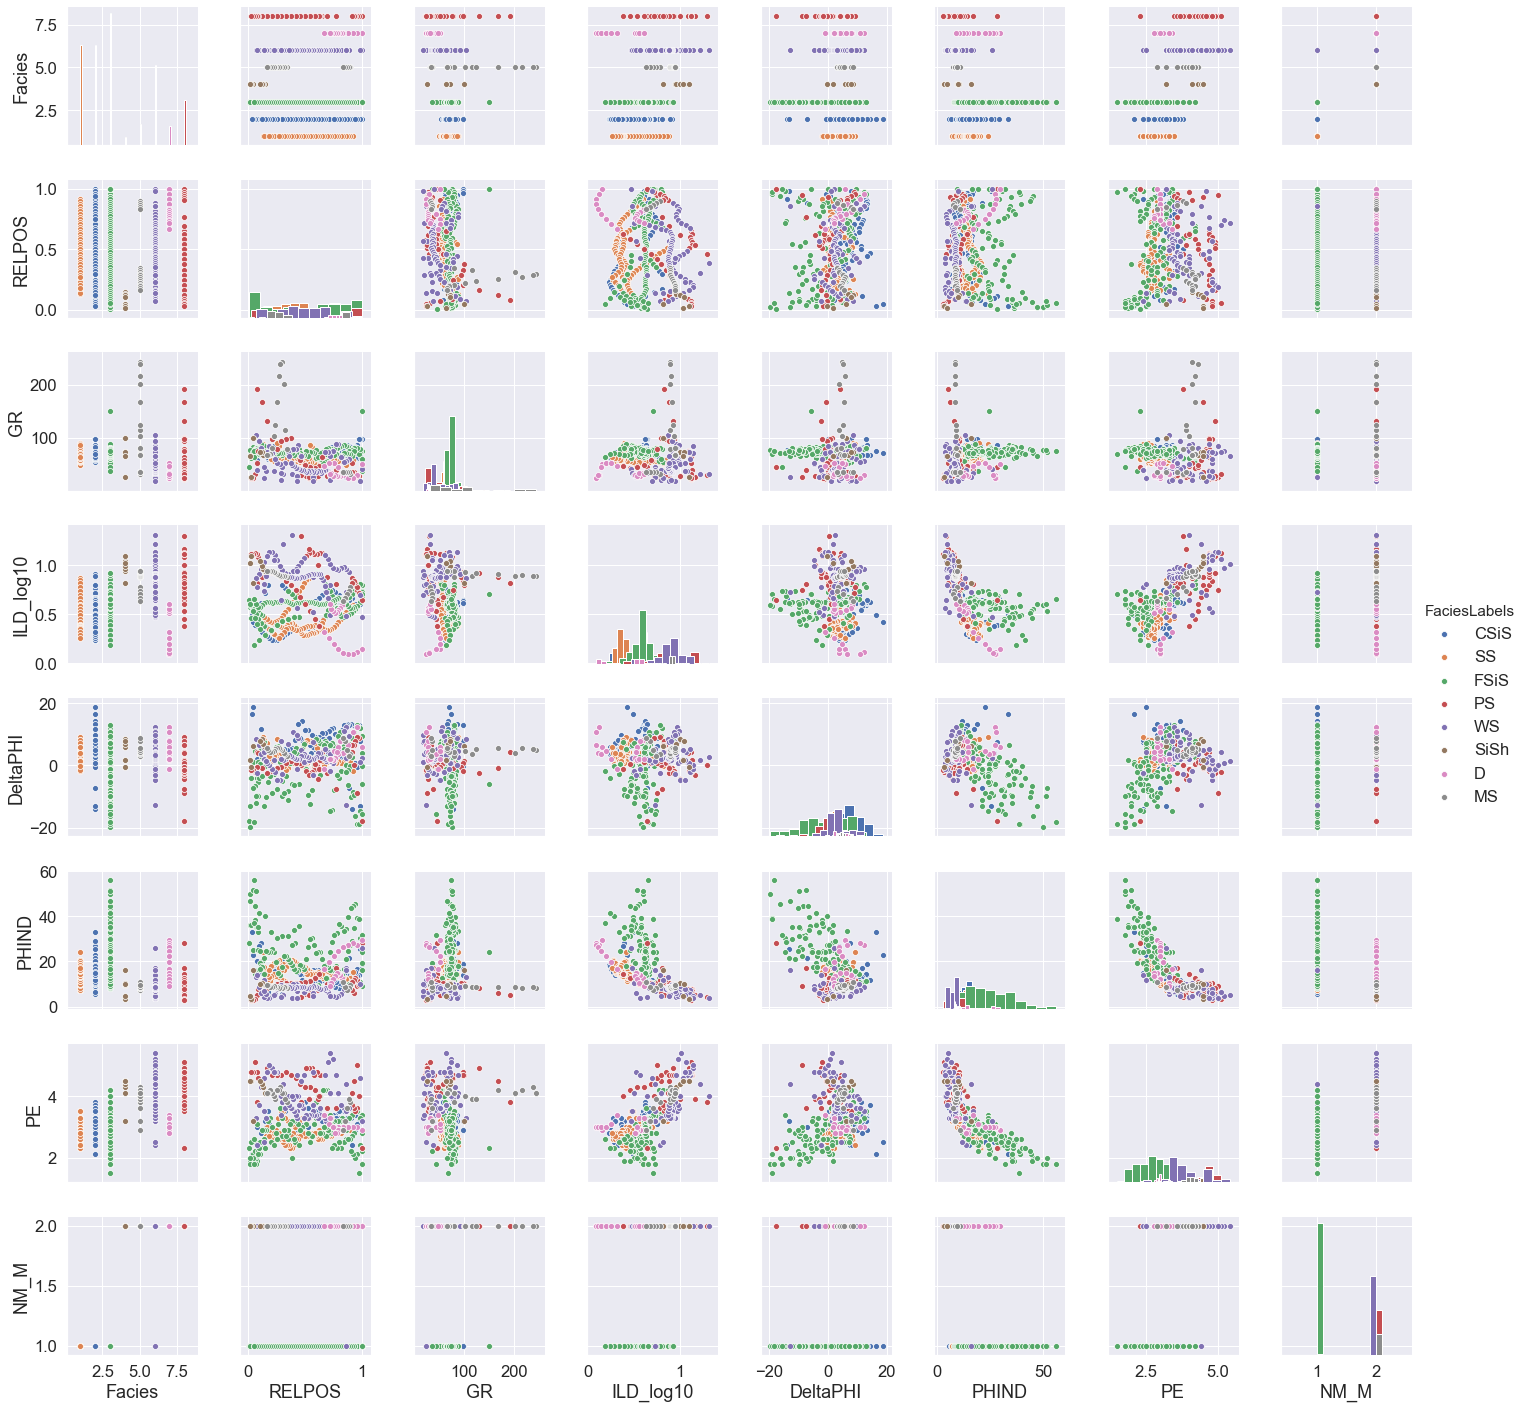

In [11]:
sns.set(font_scale=1.5) #increasing font size
sns.pairplot(training_single, diag_kind='hist',vars=plotfeatures,hue='FaciesLabels')

**Cross plot for the multiple well data:**

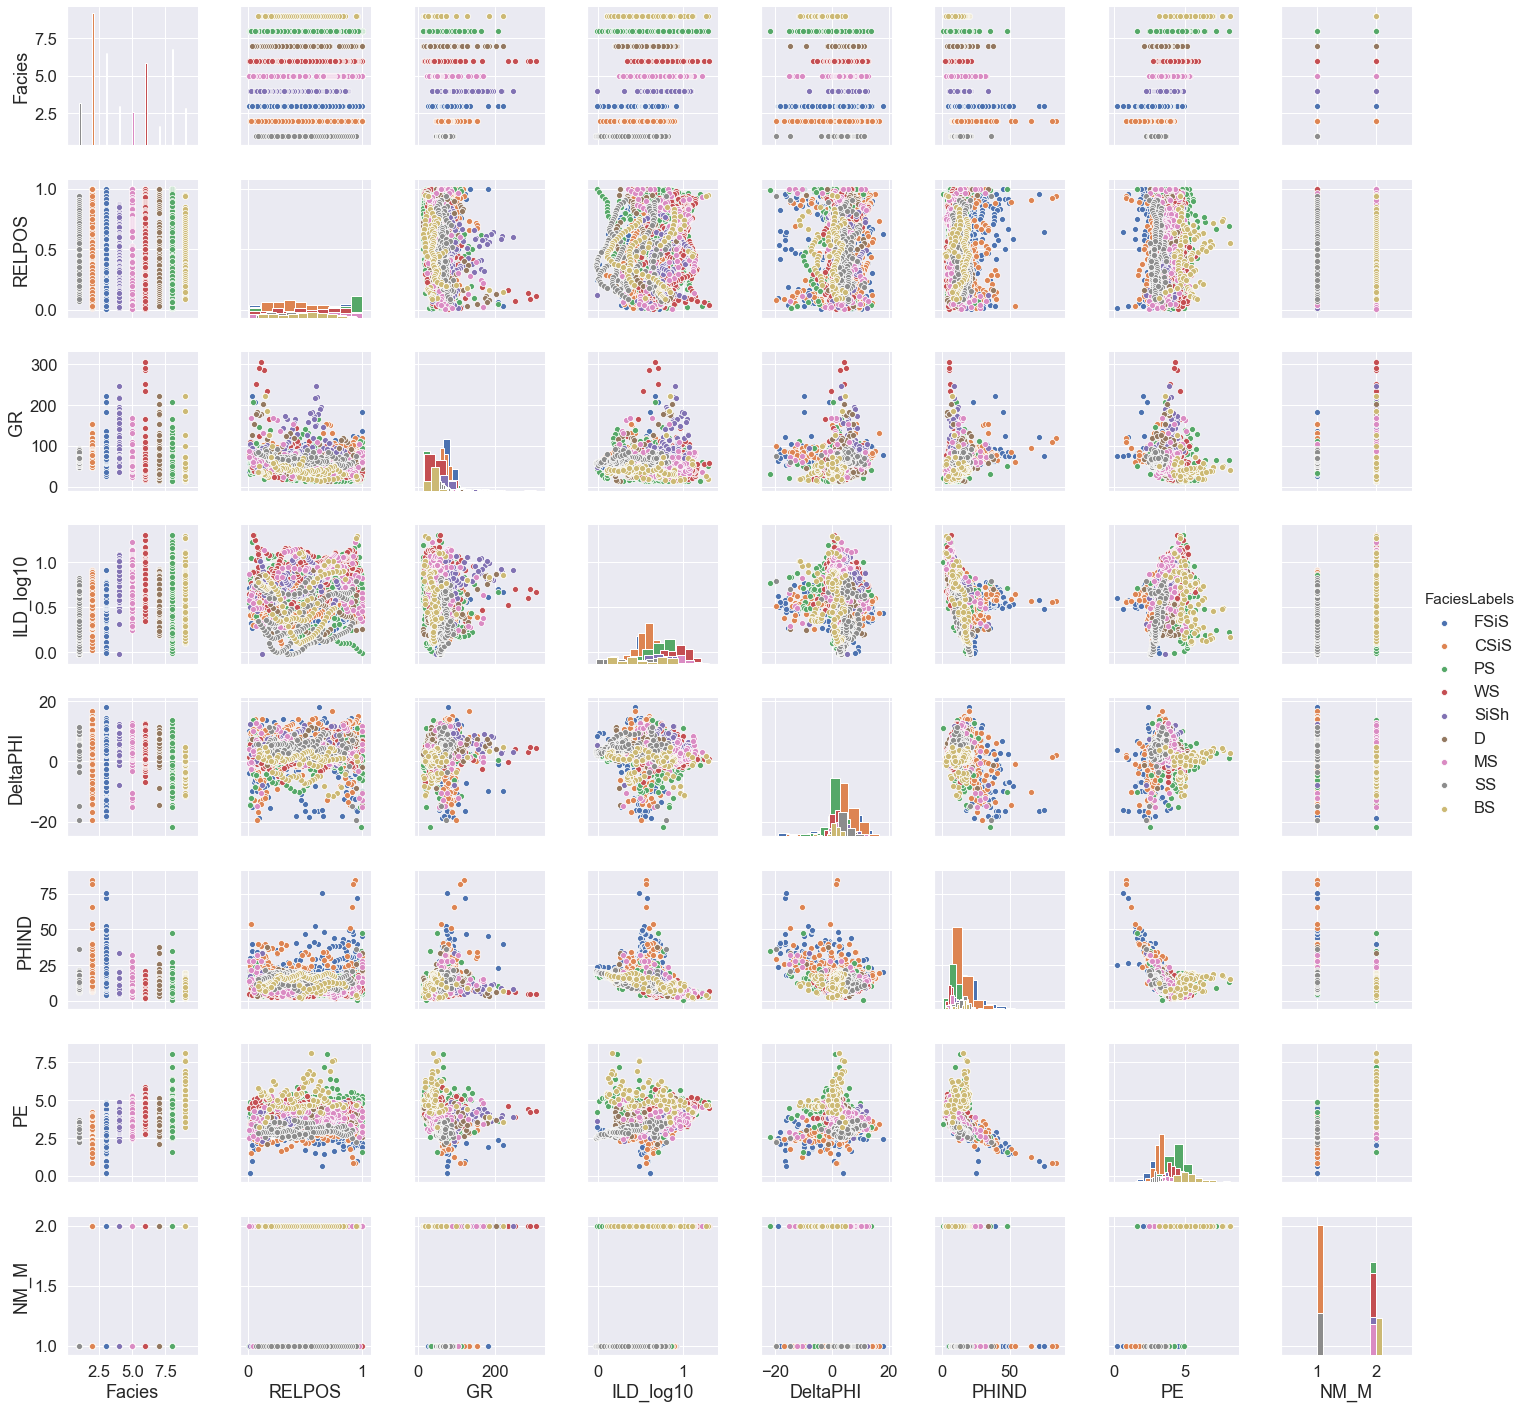

In [12]:
#complete pairplot
sns.pairplot(training_multiple, diag_kind='hist',vars=plotfeatures,hue='FaciesLabels')

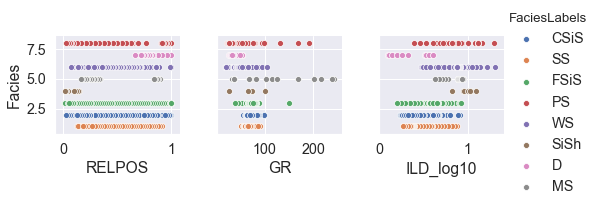

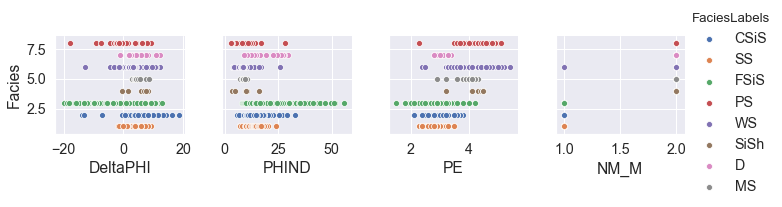

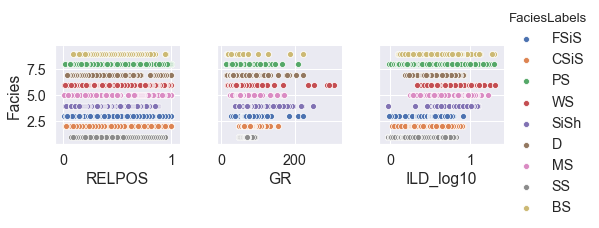

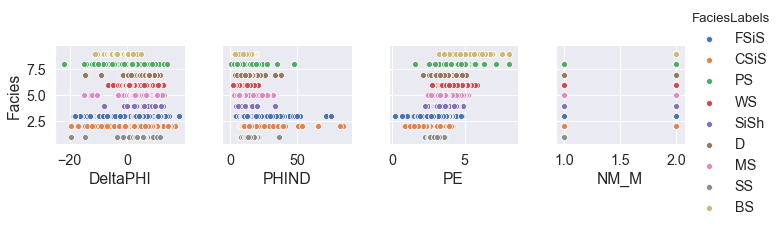

In [13]:
#pairplots with only the dependencies on facies for the document (the big plot is too much to put on one word page)
%config InlineBackend.figure_format = 'png'
sns.set(font_scale=1.3) #increasing font size

plotone_single = sns.pairplot(training_single, diag_kind='hist',y_vars = ['Facies'],x_vars=['RELPOS','GR','ILD_log10'],hue='FaciesLabels')
plottwo_single = sns.pairplot(training_single, diag_kind='hist',y_vars = ['Facies'],x_vars=['DeltaPHI','PHIND','PE','NM_M'],hue='FaciesLabels')

plotone_multiple = sns.pairplot(training_multiple, diag_kind='hist',y_vars = ['Facies'],x_vars=['RELPOS','GR','ILD_log10',],hue='FaciesLabels')
plottwo_multiple = sns.pairplot(training_multiple, diag_kind='hist',y_vars = ['Facies'],x_vars=['DeltaPHI','PHIND','PE','NM_M'],hue='FaciesLabels')


In [14]:
plotone_single.savefig('Plots etc/singleone.svg')
plottwo_single.savefig('Plots etc/singletwo.svg')

plotone_multiple.savefig('Plots etc/multione.svg')
plottwo_multiple.savefig('Plots etc/multitwo.svg')

## Vorbereitung der Datensätze
<a id="Konditionierung-daten"></a>
In den Datensätzen sind Informationen, welche für die `SVMs` übeflüssig sind. Was benötigt wird sind nur die sieben Einflussvariablen (oder *features*), welche die charakteristischen Log-Daten und geologische Variablen für eine bestimmte Fazies sind.  
Eine Fazies sollte im Idealfall also eindeutig aus der Kombination bestimmter Logwerte und geologischer Variablen identifizierbar sein.  
<hr>

Konditionieren Sie ihre Datensätze, indem Sie nur die benötigten *feature Vektoren* behalten. Speichern Sie die korrekten Faziesbenennungen als einen eigenen Vektor zur späteren Überprüfung. 
Müssen die verwendeten Datensätze [standardisiert](https://de.wikipedia.org/wiki/Standardisierung_(Statistik)) werden? Wenn ja, warum? Standardisieren Sie die Datensätze falls nötig.

In [15]:
# Speichern Sie die korrekte Fazies spalte in einem neuen Dataframe
# Erstellen Sie die feature-Vektoren (löschen der überflüssigen Spalten)

features = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE','NM_M','RELPOS'] #updating list of features for analysis

features_multiple_unscaled = training_multiple[features]
facies_multiple = training_multiple['Facies'].values

features_single_unscaled = training_single[features]
facies_single = training_single['Facies'].values


In [16]:
# standardisierung / Skalierung falls notwendig. Tipp: Siehe sklearn.preprocessing.StandardScaler().fit(...)
scaler_single = preprocessing.StandardScaler().fit(features_single_unscaled) #scaler for the single well feature data
scaler_multiple = preprocessing.StandardScaler().fit(features_multiple_unscaled) #scaler for the multiple well feature data

features_single = scaler_single.transform(features_single_unscaled) #scaling
features_multiple = scaler_multiple.transform(features_multiple_unscaled) #scaling

#print('Single well statistics: ',pd.DataFrame(features_single).describe()) #shows summary statistics to validate standardization
#print('Multiple well statistics: ',pd.DataFrame(features_multiple).describe()) #shows summary statistics to validate standardization



Da wir über keine weiteren Testdaten verfügen, nutzen Sie die Methode [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) von Scikit, um Ihre Trainingsdatensätze in **Trainingsdaten** und **Testdaten** zu unterteilen.
Nutzen Sie zwischen 10 % und 20 % der Trainingsdaten für Testzwecke. Welchen Einfluss hat der Prozentsatz der Testdaten auf die Ergebnisse/Qualität der `SVM`?

In [17]:
# trennen in Trainingsdaten und Testdaten

split_fraction = 0.15 #storing size of test data for convenience

#
while True: #this loop keeps splitting the datasets until the cv subset contains each facies at least once for reproducibility
    features_single_train, features_single_cv, facies_single_train, facies_single_cv = \
    train_test_split(features_single, facies_single, test_size = split_fraction)
    
    if 1 in facies_single_cv and 2 in facies_single_cv and 3 in facies_single_cv and 4 in facies_single_cv and  \
    5 in facies_single_cv and 6 in facies_single_cv and 7 in facies_single_cv and 8 in facies_single_cv:
        break

while True: #this loop ensures all facies are contained in the multiple_cv subset
    features_multiple_train, features_multiple_cv, facies_multiple_train, facies_multiple_cv = \
    train_test_split(features_multiple, facies_multiple, test_size = split_fraction)
    
    if 1 in facies_multiple_cv and 2 in facies_multiple_cv and 3 in facies_multiple_cv and 4 in facies_multiple_cv and  \
    5 in facies_multiple_cv and 6 in facies_multiple_cv and 7 in facies_multiple_cv and 8 in facies_multiple_cv and \
    9 in facies_multiple_cv:
        break


## Erstellung der SVM Klassifizierer
<a id="SVM-training"></a>
Die bereinigten Trainingsdatensätze sollen nun genutzt werden, um `SVMs` anzulernen. SVMs in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) können mit einer Menge an Eingabeparametern eingestellt werden. 

In [18]:
# Erstellen der SVMs und diese an Trainingsdaten trainieren und an Testdaten testen

clf_single = svm.SVC()
clf_single.fit(features_single_train,facies_single_train)

clf_multiple = svm.SVC()
clf_multiple.fit(features_multiple_train,facies_multiple_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Bewerten Sie die Qualität der beiden Klassifizierungsalgorithmen. Nutzen Sie dazu Methoden wie eine [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/), [precision und recall](https://en.wikipedia.org/wiki/Precision_and_recall), bzw den [F1-Score](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure). 

Die confusion matrix ist eine Tabelle, die dafür genutzt werden kann direkt abzuschätzen wie viele Fazies die `SVMs` richtig identifiziert haben. Die Hauptdiagonale der Matrix spiegelt die Anzahl der richtig vorhergesagten und tatsächlich richtigen Fazies wider. [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) ermöglicht schnelle und unkomplizierte Erstellung solch einer Matrix.  

*Precision* ist ein Maß, welches abschätzt wie oft ein Wert *X* richtig vorausgesagt wurde. $Pr = \frac{True\, positives}{predicted\, true}$
<hr>

*Recall* beschreibt das Verhältnis von richtig positiven Klassifizierungen zu tatsächlich positiven. $RL = \frac{True\, positives}{actual\, true}$

In [19]:
# Aufstellen der confusion matrizen
# the confusion matrix is created by making predictions for the cv dataset, which was previously set aside
prediction_single = clf_single.predict(features_single_cv)
conf_single = confusion_matrix(facies_single_cv, prediction_single)

prediction_multiple = clf_multiple.predict(features_multiple_cv)
conf_multiple = confusion_matrix(facies_multiple_cv, prediction_multiple)

print('Single well data confusion matrix: \n \n',conf_single,'\n \n')
print('Multiple well data confusion matrix: \n \n',conf_multiple,'\n')


Single well data confusion matrix: 
 
 [[10  3  0  0  0  0  0  0]
 [ 4 11  2  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0]
 [ 0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  9  0  3]
 [ 0  0  0  0  0  1  5  0]
 [ 0  0  0  0  0  2  0  3]] 
 

Multiple well data confusion matrix: 
 
 [[13 12  0  0  0  0  0  0  0]
 [ 1 67 11  0  0  0  0  0  0]
 [ 1 25 28  0  0  1  0  0  0]
 [ 0  0  0 14  0  9  0  0  0]
 [ 0  3  1  3  0 14  2  2  0]
 [ 0  0  0  1  0 43  0  6  0]
 [ 0  0  0  0  0  1  8  1  1]
 [ 0  0  1  1  1 12  1 37  2]
 [ 0  0  0  0  0  1  0  2 18]] 



Nutzen Sie die funktionen `accuracy` und `accuracy_adjacent`, um die Genauigkeit der `SVMs` zu berechnen. Beachten Sie, dass bei der `SVM`, die nur auf Daten eines Bohrlochs beruht, womöglich nicht alle Fazies im Bohrloch vertreten sind. Dementsprechend muss der array `adjacent_facies` bearbeitet werden.

In [20]:
# Erstellen Sie arrays für die benachbarten Fazies für beide Datensätze (siehe Tabelle oben). 
# ACHTUNG: Fehlt eine Fazies in einem der Datensätze, muss der Array natürlich entsprechend angeglichen werden
# First the unique facies of the single and multiple well datasets are determined before creating the matrices

print(get_unique_facies(facies_single))
print(get_unique_facies(facies_multiple))

#creating the adjacent_facies arrays
adjacent_facies_multiple = np.array([[1],
                                     [0,2],
                                     [1],
                                     [4],
                                     [3,5],
                                     [4,6],
                                     [5,7],
                                     [5,6,8],
                                     [6,7]])


adjacent_facies_single = np.array([[1],
                                  [0,2],
                                  [1],
                                  [4],
                                  [3,5],
                                  [4,6],
                                  [5,7],
                                  [5,6]
])


([2, 1, 3, 8, 6, 4, 7, 5], 8)
([3, 2, 8, 6, 4, 7, 5, 1, 9], 9)


In [21]:
#perform the accuracy calculations
print('Single Well data:')
print('accuracy: ', accuracy(conf_single))
print('accuracy adjacent:', accuracy_adjacent(conf_single,adjacent_facies_single))
print()
print('Multiple Well data:')
print('accuracy: ', accuracy(conf_multiple))
print('accuracy adjacent:', accuracy_adjacent(conf_multiple,adjacent_facies_multiple))

Single Well data:
accuracy:  0.7352941176470589
accuracy adjacent: 0.9264705882352942

Multiple Well data:
accuracy:  0.6627906976744186
accuracy adjacent: 0.9098837209302325


## Einstellen der SVM
<a id="einstellen_SVM"></a> 
Nutzen Sie eine Vergleichsprüfung, um zwei dieser Parameter, `C` und `gamma` optimal einzustellen ([RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)). 
Der Parameter `C` beeinflusst, wie viele falsche Klassifizierungen in den Trainingsdatensätzen die `SVM` zulässt. Ein großer Wert wird versuchen, Fehlklassifizierungen zu vermeiden. Wird der Wert aber zu groß abgeschätzt, wird die `SVM` nicht mehr allgemein anwendbar (Stichwort: *overfitting*). `gamma` ist ein Koeffizient der verwendeten Kernelfunktion, welcher die Entfernung zwischen zwei Vektoren *bewertet*.

Kann die Performance der `SVM` durch die Wahl eines anderen `kernels` verbessert werden?  
(Standard der `svm` Funktion ist der ([radial basis function `rbf` kernel (the default)](https://en.wikipedia.org/wiki/Radial_basis_function_kernel))  
Wie verändert sich die Performance der SVMs mit optimierten `C` und `gamma` gegenüber den *default*-Werten (wenn weder `C` noch `gamma` in der Funktion spezifiziert werden)? 


Wie ändert sich die Performance der SVM, wenn auch Klassifizierungen als richtig gewertet werden, bei denen Eine Fazies als benachbarte Fazies klassifizier wird? 
Beispiel Fazies 2:  
Facies |Label| Adjacent Facies
:---| :---: |---:
**2** Nonmarine coarse siltstone  |CSiS| 1,3  

Ohne Betrachtung der 3. Spalte würden **nur** Fazies 2 Klassifizierungen der SVM als richtig gewertet werden, die tatsächlich Fazies 2 sind. Berücksichtigt man die benachbarten Fazies, würden auch Fazies 1 oder 3 Klassifizierungen der SVM als richtig gelten, wenn eigentlich Fazies 2 vorliegt.


In [22]:
# Vergleichsprüfung mit verschiedenen Werten von C und gamma
C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])


For the tuning of the SVMs I created two functions. The functions are declared in the top section of the notebook right underneath the accuracy and accuracy_adjacent functions. One was created for the normal accuracy and one for the accuracies including neighbours. The functions output an unlabeled matrix, which displays the accuracy values of the SVM for different gamma- and C-values when applied to the cv-datasets (the ones that were not used as training data). 


In [23]:
# Trainieren der beiden SVMs mit optimierten Parametern C und gamma
#the following function performs predictions for all c & gamma values given above
#the highest accuracy result will then point to the best parameter settings without taking into account overfitting


#the accuracies for all c-gamma-combinations are printed with gamma increasing towards the right and c increasing downwards

kernel = 'rbf' #here the desired kernel function can be chosen 

accuracies_single = get_accuracy_matrix(features_single_train, facies_single_train, features_single_cv, facies_single_cv, kernel, C_range, gamma_range)
accuracies_multiple = get_accuracy_matrix(features_multiple_train, facies_multiple_train, features_multiple_cv, facies_multiple_cv, kernel, C_range, gamma_range)


print('Single well set, simple accuracy: gamma value horizontally, c-value vertically \n')
print(tabulate(accuracies_single,headers = gamma_range,showindex=C_range))
print('\n Max accuracy = ', np.max(accuracies_single)) #maximum accuracy score is given
print()

print('Multiple well set, simple accuracy: gamma value horizontally, c-value vertically \n')
print(tabulate(accuracies_multiple,headers = gamma_range,showindex=C_range))
print('\n Max accuracy = ', np.max(accuracies_multiple)) #maximum accuracy score is given
print()




Single well set, simple accuracy: gamma value horizontally, c-value vertically 

            0.0001    0.001    0.01    0.1    1.0    10.0
--------  --------  -------  ------  -----  -----  ------
    0.01      0.16     0.16    0.16   0.16   0.16    0.16
    1         0.16     0.34    0.65   0.74   0.85    0.5
    5         0.16     0.6     0.65   0.88   0.88    0.56
   10         0.34     0.65    0.69   0.9    0.9     0.56
   20         0.34     0.66    0.71   0.9    0.88    0.56
   50         0.6      0.65    0.78   0.87   0.88    0.56
  100         0.65     0.68    0.76   0.87   0.88    0.56
 1000         0.68     0.74    0.87   0.87   0.88    0.56
 5000         0.69     0.81    0.88   0.87   0.88    0.56
10000         0.74     0.79    0.87   0.87   0.88    0.56

 Max accuracy =  0.9

Multiple well set, simple accuracy: gamma value horizontally, c-value vertically 

            0.0001    0.001    0.01    0.1    1.0    10.0
--------  --------  -------  ------  -----  -----  ------
  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tabulate.py:951: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


In [24]:
#the same procedure is repeated for the adjacent_accuracy function
#the adjacent accuracies for all c-gamma-combinations are printed with gamma increasing towards the right and c increasing downwards

accuracies_adj_single = get_accuracy_adjacent_matrix(features_single_train, facies_single_train, features_single_cv, facies_single_cv, adjacent_facies_single, kernel, C_range, gamma_range)
accuracies_adj_multiple = get_accuracy_adjacent_matrix(features_multiple_train, facies_multiple_train, features_multiple_cv, facies_multiple_cv, adjacent_facies_multiple, kernel, C_range, gamma_range)

print('Single well set, adjacent accuracy: gamma value horizontally, c-value vertically \n')
print(tabulate(accuracies_adj_single,headers = gamma_range,showindex=C_range))
print('\n Max accuracy = ', np.max(accuracies_adj_single)) #maximum accuracy score is given
print()

print('Multiple well set, adjacent accuracy: gamma value horizontally, c-value vertically \n')
print(tabulate(accuracies_adj_multiple,headers = gamma_range,showindex=C_range))
print('\n Max accuracy = ', np.max(accuracies_adj_multiple)) #maximum accuracy score is given
print()


Single well set, adjacent accuracy: gamma value horizontally, c-value vertically 

            0.0001    0.001    0.01    0.1    1.0    10.0
--------  --------  -------  ------  -----  -----  ------
    0.01      0.41     0.41    0.41   0.41   0.41    0.41
    1         0.41     0.65    0.96   0.91   0.96    0.63
    5         0.41     0.93    0.9    0.97   0.96    0.66
   10         0.65     0.96    0.9    0.99   0.96    0.66
   20         0.72     0.94    0.88   0.99   0.96    0.66
   50         0.93     0.88    0.94   0.97   0.96    0.66
  100         0.96     0.87    0.94   0.97   0.96    0.66
 1000         0.87     0.91    0.96   0.97   0.96    0.66
 5000         0.9      0.94    0.96   0.97   0.96    0.66
10000         0.91     0.96    0.96   0.97   0.96    0.66

 Max accuracy =  0.99

Multiple well set, adjacent accuracy: gamma value horizontally, c-value vertically 

            0.0001    0.001    0.01    0.1    1.0    10.0
--------  --------  -------  ------  -----  -----  ---

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tabulate.py:951: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


The next four cells output the accuracy matrices as heatmaps using seaborn

Single well, simple acc:


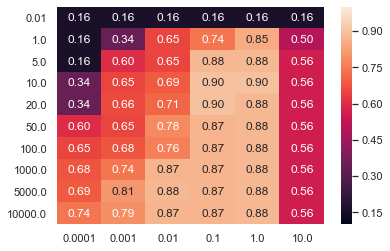

In [25]:
sns.set(font_scale=1)
print('Single well, simple acc:')
heat_simple_single = sns.heatmap(accuracies_single,xticklabels=gamma_range,yticklabels=C_range,vmin=0.1,vmax=1,annot=True,fmt='.2f')


Multi well, simple acc:


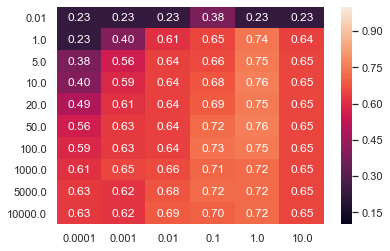

In [26]:
sns.set(font_scale=1)
print('Multi well, simple acc:')
heat_simple_multiple = sns.heatmap(accuracies_multiple,xticklabels=gamma_range,yticklabels=C_range,vmin=0.1,vmax=1,annot=True,fmt='.2f')

Single well, adjacent accuracy:


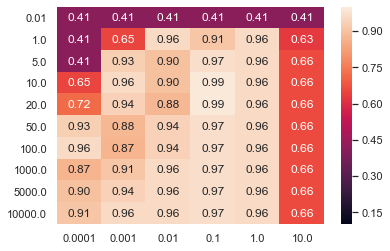

In [27]:
sns.set(font_scale=1)
print('Single well, adjacent accuracy:')
heat_adj_single = sns.heatmap(accuracies_adj_single,xticklabels=gamma_range,yticklabels=C_range,vmin=0.1,vmax=1,annot=True,fmt='.2f')

Multi well, adjacent accuracy:


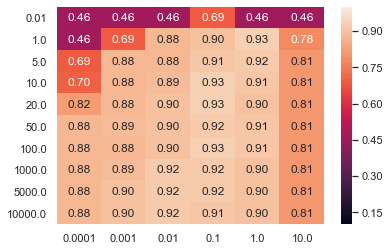

In [28]:
sns.set(font_scale=1)
print('Multi well, adjacent accuracy:')
heat_adj_multiple = sns.heatmap(accuracies_adj_multiple,xticklabels=gamma_range,yticklabels=C_range,vmin=0.1,vmax=1,annot=True,fmt='.2f')

In [37]:
# Confusion Matrizen beider Datensätze mit und ohne benachbarte Fazies
#confusion matrices are created for the following c- and gamma values 
#c and gamma values are chosen based on the accuracy results above
c_single = 10
gamma_single = 0.1

c_multiple = 10
gamma_multiple = 1

clf_single = svm.SVC(C=c_single,gamma=gamma_single,kernel=kernel) #SVM for single well data is created
clf_single.fit(features_single_train,facies_single_train)
prediction_single = clf_single.predict(features_single_cv)

clf_multiple = svm.SVC(C=c_multiple,gamma=gamma_multiple,kernel=kernel) #SVM for multiple well data is created
clf_multiple.fit(features_multiple_train,facies_multiple_train)
prediction_multiple = clf_multiple.predict(features_multiple_cv)

#printing confusion matrix & accuracies for single-well data with the chosen parameters:
print('Single well data confusion matrix: \n', confusion_matrix(facies_single_cv,prediction_single),)
print('Accuracy = ',round(accuracy(confusion_matrix(facies_single_cv,prediction_single)),2))
print('Accuracy incl. adjacent = ',round(accuracy_adjacent(confusion_matrix(facies_single_cv,prediction_single),adjacent_facies_single),2),'\n')

#printing confusion matrix & accuracies for multiple-well data with the chosen parameters:
print('Multiple well data confusion matrix: \n', confusion_matrix(facies_multiple_cv,prediction_multiple),)
print('Accuracy = ',round(accuracy(confusion_matrix(facies_multiple_cv,prediction_multiple)),2))
print('Accuracy incl. adjacent = ',round(accuracy_adjacent(confusion_matrix(facies_multiple_cv,prediction_multiple),adjacent_facies_multiple),2),'\n')


Single well data confusion matrix: 
 [[11  2  0  0  0  0  0  0]
 [ 2 14  1  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0]
 [ 0  0  0  0  2  0  0  0]
 [ 0  0  0  1  0 11  0  0]
 [ 0  0  0  0  0  1  5  0]
 [ 0  0  0  0  0  0  0  5]]
Accuracy =  0.9
Accuracy incl. adjacent =  0.99 

Multiple well data confusion matrix: 
 [[23  1  1  0  0  0  0  0  0]
 [ 1 58 20  0  0  0  0  0  0]
 [ 1  7 43  3  0  0  0  1  0]
 [ 0  0  0 18  3  1  0  1  0]
 [ 0  2  3  1 10  7  0  2  0]
 [ 0  0  0  3  1 40  0  6  0]
 [ 0  0  0  0  0  0  9  1  1]
 [ 0  1  0  1  3  9  1 38  2]
 [ 0  0  0  0  0  0  0  0 21]]
Accuracy =  0.76
Accuracy incl. adjacent =  0.91 



## Anwendung der SVM Modelle auf einen Blind-Datensatz
<a id="Blind-test"></a>
Neben den zwei Trainingsdatensätzen haben Sie eine csv Datei mit dem Namen `Blind_single_well_n.csv` erhalten (`n` sollte die gleiche Zahl sein wie bei den Trainingsdatensätzen!). Analog zu den Schritten mit den Trainingsdatensätzen müssen Sie den Blind-Datensatz vorbereiten, einen *feature Vektor* erstellen und die Vorhersagen durch die beiden `SVMs` als neue Spalten dem Blind-Datensatzes hinzufügen.   
Der Blind-Datensatz enthält eine Faziesklassifizierung (`Facies`), die Sie nutzen können, um die Vorhersagen der beiden `SVMs` nicht nur untereinander zu vergleichen, sondern auch gegenüber der wirklichen Fazieseinteilung. 

In [38]:
# Einladen des Blinddatensatzes
blind = pd.read_csv('Blind_single_well_8.csv')
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
466,8,C LM,SHRIMPLIN,3026.0,17.92,0.808,1.5,9.730,5.4,2,0.049,PS
467,8,C LM,SHRIMPLIN,3026.5,16.51,0.814,2.0,8.275,5.5,2,0.039,PS
468,8,C LM,SHRIMPLIN,3027.0,21.94,0.820,3.3,7.680,5.4,2,0.029,PS
469,8,C LM,SHRIMPLIN,3027.5,32.54,0.821,2.5,7.445,5.8,2,0.020,PS


In [39]:
#changing to category type
blind['Formation'].astype('category') 
blind['Well Name'].astype('category') 

#removing NaNs
blind_len_bf = len(blind) #stores the number of data points
blind.dropna(how='any', inplace=True)
blind_len_at = len(blind) #stores new number of data points after NaN removal
print('Blind: ', blind_len_bf-blind_len_at,' rows were removed due to NaN values') #outputs number of removed data points

#After removal summary statistics are displayed
print(blind.describe())

Blind:  0  rows were removed due to NaN values
           Facies        Depth          GR   ILD_log10    DeltaPHI  \
count  471.000000   471.000000  471.000000  471.000000  471.000000   
mean     4.384289  2910.501062   69.408896    0.659679    7.708493   
std      2.207070    68.055644   37.299536    0.232894    4.279453   
min      2.000000  2793.000000   13.280000    0.297000   -4.300000   
25%      2.500000  2851.750000   46.895000    0.486000    4.300000   
50%      3.000000  2910.500000   69.480000    0.580000    7.300000   
75%      6.000000  2969.250000   85.995000    0.827500   11.150000   
max      9.000000  3028.000000  361.150000    1.480000   18.500000   

            PHIND          PE        NM_M      RELPOS  
count  471.000000  471.000000  471.000000  471.000000  
mean    12.173705    4.219958    1.488323    0.514482  
std      5.317152    0.902823    0.500395    0.289757  
min      1.590000    2.700000    1.000000    0.010000  
25%      8.065000    3.400000    1.000000 

The label vector is just the `Facies` column:

In [40]:
# Vorbereiten des Blinddatensatzes (Erstellen Feature Vektor, Standardisieren der Daten etc)
#features vector was already created above

facies_blind = blind['Facies']
features_blind_unscaled = blind[features]

#getting the unique facies to create the adjacent matrix for the accuracy_adjacent function later
print(get_unique_facies(facies_blind))

#normalizing the features
features_blind_single = scaler_single.transform(features_blind_unscaled)
features_blind_multiple = scaler_multiple.transform(features_blind_unscaled)

([3, 2, 8, 6, 7, 4, 5, 9], 8)


In [41]:
# Evaluieren durch die SVMs
blind['PredictionSingle'] = clf_single.predict(features_blind_single)
blind['PredictionMultiple'] = clf_multiple.predict(features_blind_multiple)


[[ 0  0  0  0  0  0  0  0  0]
 [10 82 26  0  0  0  0  0  0]
 [ 1 55 65  0  1  0  0  1  0]
 [ 0  0  5  4  0  4  0  5  0]
 [ 0  0  0  2 10 28  0 23  0]
 [ 0  1  5  3  5 25  2 21  1]
 [ 0  0  0  0  1  2  0  2  0]
 [ 0  0  6  0  2  4  1 48  8]
 [ 0  0  0  0  0  0  0  0 12]]
Accuracy single =  0.3970276008492569
Accuracy multiple =  0.5222929936305732
Accuracy adjacent single =  0.802547770700637
Accuracy adjacent multiple =  0.8301486199575372


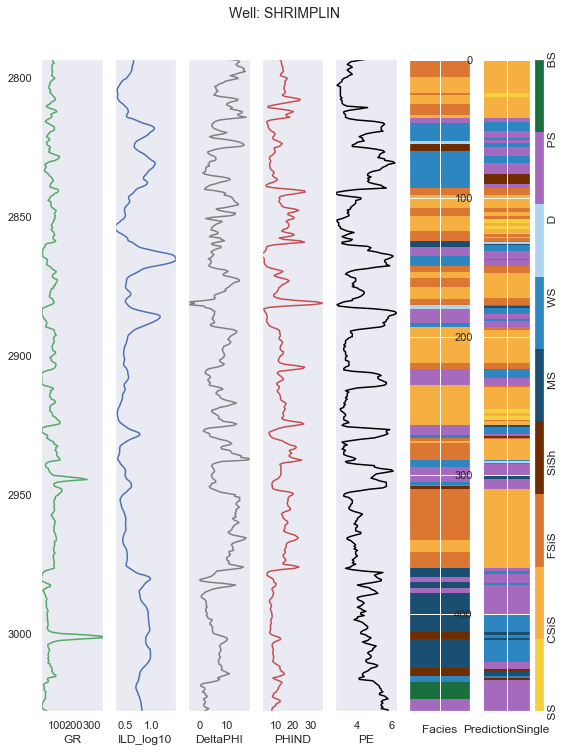

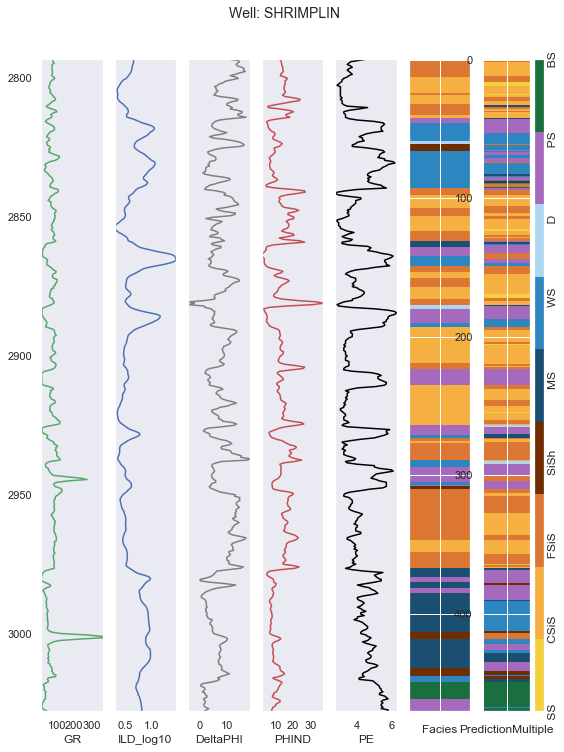

In [42]:
# Confusion Matrizen und Vergleichsplots für das Blindbohrloch (ähnlich zu oben. 
# Siehe Routine: compare_facies_plot)

#matrix for the adjacent facies
adjacent_facies_blind = np.array([[1],
                                  [0,2],
                                  [1],
                                  [4],
                                  [3,5],
                                  [4,6],
                                  [5,7],
                                  [5,6,8],
                                  [6,7]])

#making confusion matrices
conf_blind_single = confusion_matrix(facies_blind, blind['PredictionSingle'])
conf_blind_multiple = confusion_matrix(facies_blind, blind['PredictionMultiple'])
print(conf_blind_multiple)


compare_facies_plot(blind,'PredictionSingle',facies_colors)
compare_facies_plot(blind,'PredictionMultiple',facies_colors)
print('Accuracy single = ',accuracy(conf_blind_single))
print('Accuracy multiple = ',accuracy(conf_blind_multiple))
print('Accuracy adjacent single = ',accuracy_adjacent(conf_blind_single,adjacent_facies_blind))
print('Accuracy adjacent multiple = ',accuracy_adjacent(conf_blind_multiple,adjacent_facies_blind))